In [2]:
from collections import defaultdict
import re
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
with open('../data/expression/expressed.names') as infile:
    finz_znfs = [line.strip() for line in infile]

expression_df = pd.read_csv('../data/expression/White2017_expression_tpm.tsv',
                            sep='\t',
                            skiprows=4).fillna(0.0)
devstages = list(expression_df.columns)[2:]
melted_expression_df = expression_df.melt(id_vars=['Gene ID', 'Gene Name'], var_name='Stage', value_name='TPM')
print(melted_expression_df.head())
print(set(melted_expression_df['Stage'].tolist()))

              Gene ID  Gene Name   Stage    TPM
0  ENSDARG00000000001    slc35a5  zygote    2.0
1  ENSDARG00000000002     ccdc80  zygote    0.3
2  ENSDARG00000000018       nrf1  zygote    7.0
3  ENSDARG00000000019      ube2h  zygote  144.0
4  ENSDARG00000000068  slc9a3r1a  zygote   42.0
{'gastrula 50%-epiboly', 'segmentation 20-25 somites', 'larval day 4', 'gastrula 75%-epiboly', 'segmentation 14-19 somites', 'cleavage 2-cell', 'hatching long-pec', 'pharyngula prim-5', 'blastula dome', 'larval day 5', 'pharyngula prim-15', 'pharyngula prim-25', 'blastula 1k-cell', 'blastula 128-cell', 'gastrula shield', 'segmentation 1-4 somites', 'larval protruding mouth', 'zygote'}


In [4]:
tpms = list(melted_expression_df.loc[melted_expression_df['Gene ID'].isin(finz_znfs)] \
    .sort_values('TPM', ascending=False)[['Gene ID', 'TPM']] \
    .itertuples(index=False, name=None))
hue_order_dict = {}
for gene, tpm in tpms:
    if gene not in hue_order_dict:
        hue_order_dict[gene] = tpm
    elif tpm > hue_order_dict[gene]:
        hue_order_dict[gene] = tpm
hue_order = sorted(list(hue_order_dict.keys()), key=lambda x: hue_order_dict[x])
melted_expression_df['TPM+1'] = melted_expression_df['TPM'] + 1


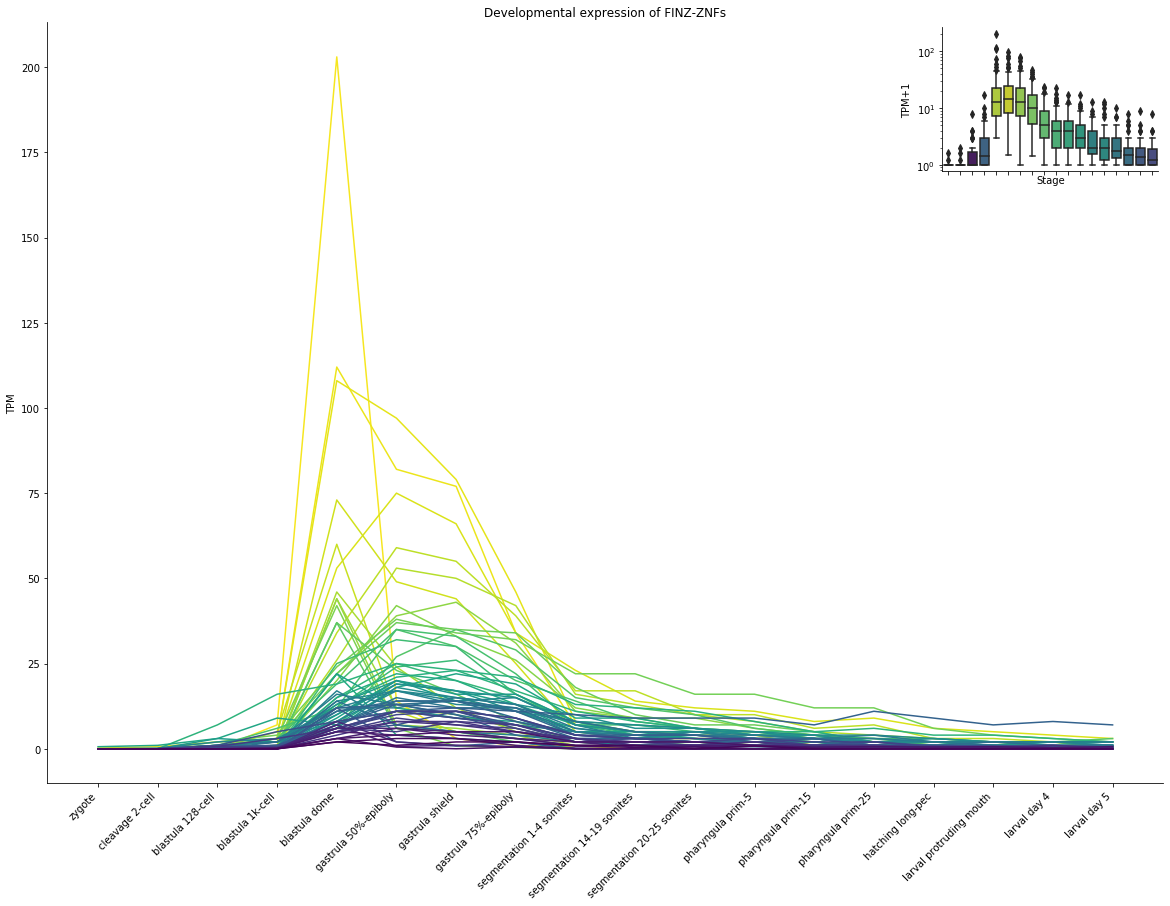

In [5]:
fig, ax = plt.subplots(figsize=(20, 14))

sns.lineplot(data=melted_expression_df.loc[melted_expression_df['Gene ID'].isin(finz_znfs)],
             x='Stage', 
             y='TPM', 
             hue='Gene ID',
             sort=False,
             palette='viridis_r',
             hue_order=hue_order[::-1],
             ax=ax)
ax.set_title('Developmental expression of FINZ-ZNFs')
ax.get_legend().remove()
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')

axins = inset_axes(ax, width=3, height=2)
axins.tick_params(labelleft=True, labelbottom=False)

box_hue_order = melted_expression_df.loc[melted_expression_df['Gene ID'].isin(finz_znfs)] \
    .groupby('Stage') \
    .median() \
    .reset_index() \
    .sort_values('TPM+1')['Stage'] \
    .to_list()

sns.boxplot(data=melted_expression_df.loc[melted_expression_df['Gene ID'].isin(finz_znfs)],
            x='Stage',
            y='TPM+1',
            hue='Stage',
            dodge=False,
            palette='viridis', 
            hue_order=box_hue_order,
            ax=axins)
axins.set_yscale('log')
axins.get_legend().remove()
plt.xticks(rotation=45, ha='right')

sns.despine()
plt.show()

fig.savefig('/Users/jonwells/Desktop/znf_expression.pdf', bbox_inches='tight')

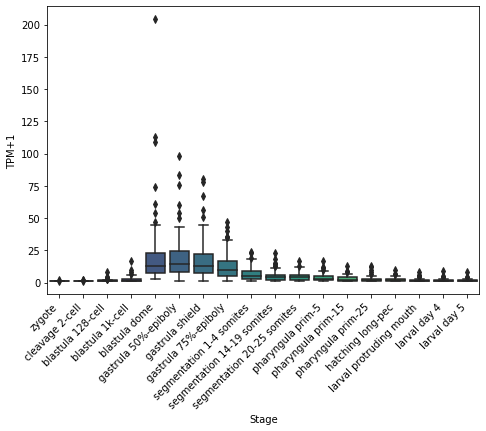

In [6]:
# fig, ax = plt.subplots(figsize=(10, 5))
ax2 = plt.axes([0,0,1,1])
melted_expression_df['TPM+1'] = melted_expression_df['TPM'] + 1

sns.boxplot(data=melted_expression_df.loc[melted_expression_df['Gene ID'].isin(finz_znfs)],
            x='Stage',
            y='TPM+1',
            palette='viridis', ax=ax2)
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right')
plt.show()

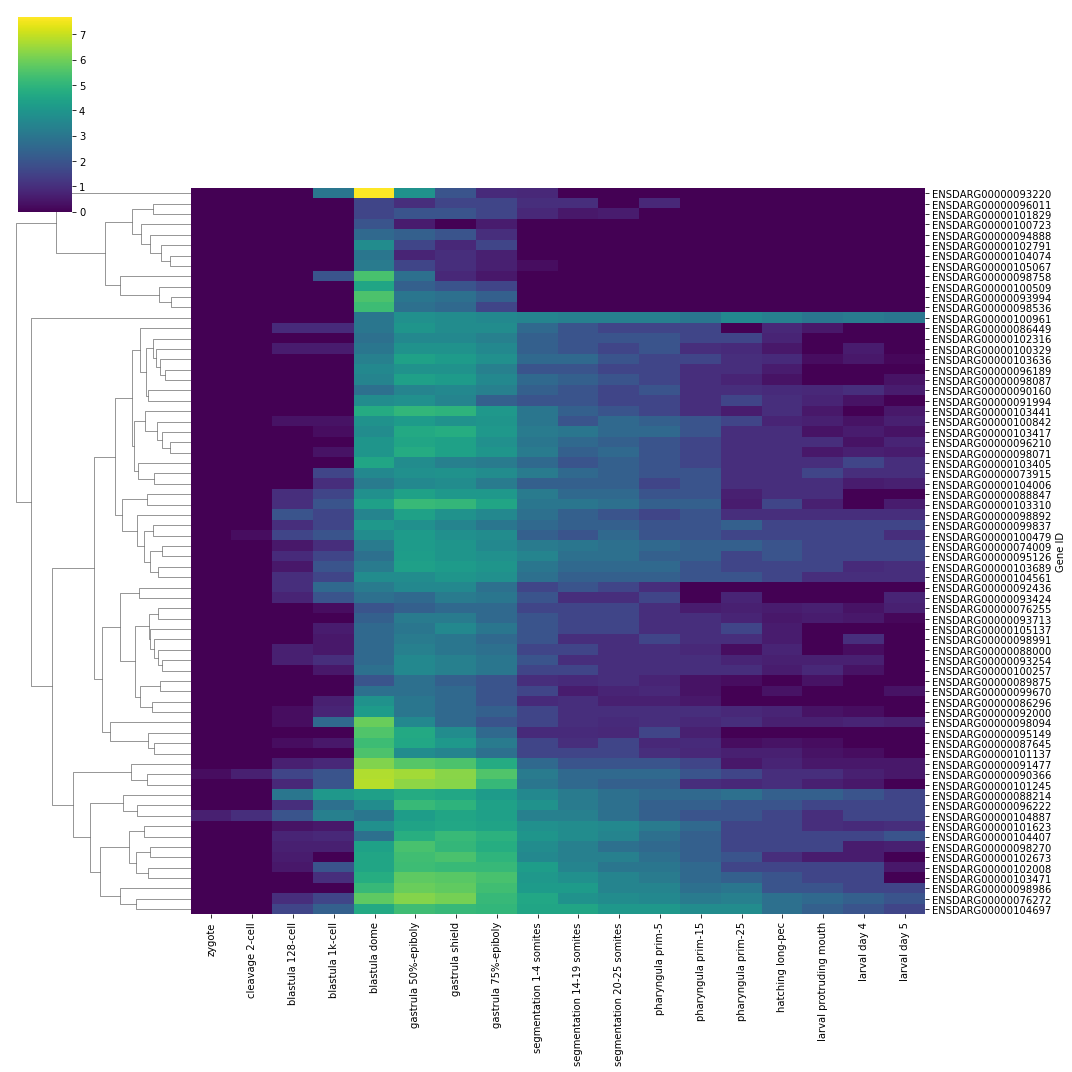

In [7]:
finz_matrix = expression_df.loc[expression_df['Gene ID'].isin(finz_znfs)].drop('Gene Name', axis=1).set_index('Gene ID')
finz_matrix = np.log2(finz_matrix + 1)

# fig, ax = plt.subplots(figsize=(15, 10))
sns.clustermap(data=finz_matrix, cmap="viridis", col_cluster=False, figsize=(15,15), yticklabels=True)
plt.show()

In [8]:
def avg_replicates(df):
    stages = defaultdict(list)
    for col in df.columns[1:]:
        stage = '_'.join(col.split('_')[:-2])
        stages[stage].append(col)
    for stage in stages:
        df[stage] = df[stages[stage]].median(axis=1)
        df = df.drop(stages[stage], axis=1)
    return df

In [9]:
df_genes_norm = pd.read_csv('../data/expression/counts_Genes_norm.tab',
                            sep='\t')
df_genes_norm = avg_replicates(df_genes_norm)
melted_genes = df_genes_norm.melt(id_vars='Genes', var_name='stage', value_name='norm_counts')
melted_genes['type'] = 'gene'

df_tes_norm = pd.read_csv('../data/expression/counts_TE_loci_norm.tab',
                            sep='\t')
df_tes_norm = avg_replicates(df_tes_norm)
df_tes_norm['TEs'] = df_tes_norm['TEs'].apply(lambda x: re.sub('_dup\d.*', '', x))
df_tes_norm = df_tes_norm.groupby('TEs').sum().reset_index()
melted_tes = df_tes_norm.melt(id_vars='TEs', var_name='stage', value_name='norm_counts')
melted_tes = melted_tes.rename({'TEs': 'Genes'}, axis=1)
melted_tes['type'] = 'te'

expression_df2 = pd.concat([melted_tes, melted_genes], ignore_index=True)
print(expression_df2.head())

           Genes   stage   norm_counts type
0       ACROBAT1  1_cell      2.378126   te
1       ACROBAT2  1_cell     42.384083   te
2          ANGEL  1_cell  10879.436503   te
3    Academ-1_DR  1_cell      0.000000   te
4  Academ-N1_DRe  1_cell    171.169842   te


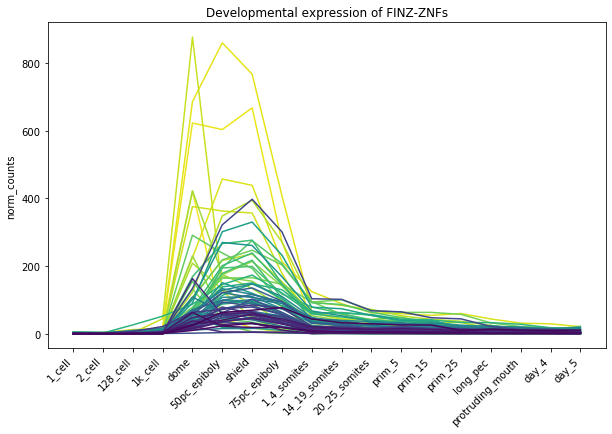

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=melted_genes.loc[melted_genes['Genes'].isin(finz_znfs)],
             x='stage', 
             y='norm_counts', 
             hue='Genes',
             sort=False,
             palette='viridis_r',
             hue_order=hue_order[::-1],
             ax=ax)
ax.set_title('Developmental expression of FINZ-ZNFs')
ax.get_legend().remove()
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()


In [14]:
for i in set(melted_tes['Genes']):
    for j in finz_znfs:
        print(i, j, stats.spearmanr(melted_tes.loc[melted_tes['Genes'] == i, 'norm_counts'],
                                    melted_genes.loc[melted_genes['Genes'] == j, 'norm_counts'])[0])


BEL1-LTR_DR ENSDARG00000073915 0.29131889387959337
BEL1-LTR_DR ENSDARG00000074009 0.3807127782830787
BEL1-LTR_DR ENSDARG00000076255 0.31340444179104265
BEL1-LTR_DR ENSDARG00000076272 0.29131889387959337
BEL1-LTR_DR ENSDARG00000086296 0.27344011699889625
BEL1-LTR_DR ENSDARG00000086449 0.34811030279474875
BEL1-LTR_DR ENSDARG00000087645 0.2555613401181992
BEL1-LTR_DR ENSDARG00000088000 0.33233491142942784
BEL1-LTR_DR ENSDARG00000088214 0.37946513140367893
BEL1-LTR_DR ENSDARG00000088847 0.335489989702492
BEL1-LTR_DR ENSDARG00000089875 0.2545096473605111
BEL1-LTR_DR ENSDARG00000090160 0.318662905579483
BEL1-LTR_DR ENSDARG00000090366 0.31849843439145353
BEL1-LTR_DR ENSDARG00000091477 0.2481994908143828
BEL1-LTR_DR ENSDARG00000091994 0.3494534670521713
BEL1-LTR_DR ENSDARG00000092000 0.16511576295702585
BEL1-LTR_DR ENSDARG00000092436 0.2596456527663797
BEL1-LTR_DR ENSDARG00000093220 0.33028664418686215
BEL1-LTR_DR ENSDARG00000093254 0.36809246519082195
BEL1-LTR_DR ENSDARG00000093424 0.39102778

KeyboardInterrupt: 